In [1]:
import torch.nn as nn
import torch
from torch import optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


import pywt
from pywt._doc_utils import draw_2d_wp_basis, wavedec2_keys

In [3]:
def get_im_decomp(images, nlevel = 1, nbatch = 10):
    '''
    IN: nbatch number of RGB images of shape [nbatch, 3, n, n]; torch tensor format
    OUT: RGB n-level decomp of the image of shape [nbatch, 3, n, n]; torch tensor format
    
    Splits the image into its constituent colour channels, then finds the n-level 2d wavelet decomp
    for each, formats that data as required and stacks the colour channels again.
    '''
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    images = images.cpu()
    images = torch.Tensor.numpy(images)
    image_decomp_final = np.zeros((nbatch, 3, 64, 64))

    for image_id, image in enumerate(images):
        image_r_init = np.asarray(image[0, :, :])
        image_g_init = np.asarray(image[1, :, :])
        image_b_init = np.asarray(image[2, :, :])

        # Finds channelwise n-level wavelet decomp 
        image_r = pywt.wavedec2(image_r_init, 'db2', mode = 'periodization',  level = nlevel)
        image_g = pywt.wavedec2(image_g_init, 'db2', mode = 'periodization',  level = nlevel)
        image_b = pywt.wavedec2(image_b_init, 'db2', mode = 'periodization',  level = nlevel)
    
        # Rearranges the channels back into image form
        image_decomp_r, waste = pywt.coeffs_to_array(image_r)
        image_decomp_g, waste = pywt.coeffs_to_array(image_g)
        image_decomp_b, waste = pywt.coeffs_to_array(image_b)
    
        # Reassembles the channels into an RGB image
        image_decomp = [image_decomp_r, image_decomp_g, image_decomp_b]
        for channel in range(3):
            image_decomp_final[image_id, channel, :, :] = image_decomp[channel]
    
    image_decomp_final = torch.from_numpy(image_decomp_final).float()
    image_decomp_final = image_decomp_final.to(device)
    
    return image_decomp_final

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((64, 64))])

batch_size = 10

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 64, 64])


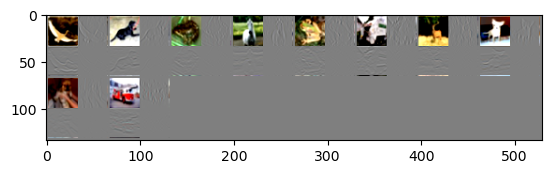

bird  dog   frog  horse frog  truck deer  dog   dog   truck


In [7]:
#functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


#get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = get_im_decomp(images); print(images.shape)

#show images
imshow(torchvision.utils.make_grid(images.cpu()))
#print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [33]:
#s is a scale parameter for the model. the # of parameters is quadratic in s; n parameters becomes 2^s parameters. s must be an integer, i think.
s = 1

class WaveNet(nn.Module):
    def __init__(self):
        super(WaveNet, self).__init__()

        # Activation function
        self.relu = nn.ReLU(inplace = True)

        # First two convolutional layers
        self.convk11 = nn.Conv2d(in_channels = 3, out_channels = 16*s, kernel_size = 3, padding = 1)
        self.convk12 = nn.Conv2d(in_channels = 16*s, out_channels = 16*s, kernel_size = 3, padding = 1, stride = 2)

        # Second pair of convolutional layers
        self.convk21 = nn.Conv2d(in_channels = 160*s, out_channels = 24*s, kernel_size = 3, padding = 1)
        self.convk22 = nn.Conv2d(in_channels = 24*s, out_channels = 24*s, kernel_size = 3, padding = 1, stride = 2)

        # Second projection shortcut
        self.projection2 = nn.Conv2d(in_channels = 144*s, out_channels = 96*s, kernel_size = 1, stride = 2)

        # Third pair of convolutional layers
        self.convk31 = nn.Conv2d(in_channels = 200*s, out_channels = 64*s, kernel_size = 3, padding = 1)
        self.convk32 = nn.Conv2d(in_channels = 64*s, out_channels = 48*s, kernel_size = 3, padding = 1) #as above

        # Third projection shortcut
        self.projection3 = nn.Conv2d(in_channels = 200*s, out_channels = 128*s, kernel_size = 1) #as above

        # Fourth conv layer
        self.convk41 = nn.Conv2d(in_channels = 176*s, out_channels = 128*s, kernel_size = 3, padding = 1)
        self.convk42 = nn.Conv2d(in_channels = 128*s, out_channels = 48*s, kernel_size = 3, padding = 1) #as above

        # Average pooling layer to trim parameters and allow a tractible output layer
        self.avgpool = nn.AvgPool2d(kernel_size = 10)

        # Fully connected output layer
        self.output = nn.Linear(48, 10)

        # ====================================
    
        # Conv layer for level-2,-3,-4 decomps
        # Level 2
        self.convl2_1 = nn.Conv2d(in_channels = 3, out_channels = 16*s, kernel_size = 3, padding = 1)

        # Level 3
        self.convl3_1 = nn.Conv2d(in_channels = 3, out_channels = 32*s, kernel_size = 3, padding = 1)
        self.convl3_2 = nn.Conv2d(in_channels = 32*s, out_channels = 16*s, kernel_size = 3, padding = 1) 

        # Projection shortcuts for level-2,-3,-4 decomps
        self.projectionl1 = nn.Conv2d(in_channels = 3, out_channels = 64*s, kernel_size = 1, stride = 2)
        self.projectionl2 = nn.Conv2d(in_channels = 3, out_channels = 64*s, kernel_size = 1)   
        self.projectionl3 = nn.Conv2d(in_channels = 3, out_channels = 64*s, kernel_size = 1)

    def forward(self, x):
        if (debug == True):
            l1_decomp = get_im_decomp(x, nlevel = 1, nbatch = batch_size)
            l2_decomp = get_im_decomp(x, nlevel = 2, nbatch = batch_size)[:, :, 0:32, 0:32]
            l3_decomp = get_im_decomp(x, nlevel = 3, nbatch = batch_size)[:, :, 0:16, 0:16]
    
            # All the data needed for concat1
            shortcut_11 = self.relu(self.projectionl1(l1_decomp)); print('shortcut_11 shape: ', shortcut_11.shape)
            shortcut_12 = self.relu(self.projectionl2(l2_decomp)); print('shortcut_12 shape: ', shortcut_12.shape)
            conv_l2 = self.relu(self.convl2_1(l2_decomp)); print('conv_l2 shape: ', conv_l2.shape)
            
            x = self.relu(self.convk11(l1_decomp)); print('x shape: ', x.shape)
            checkpoint1 = self.relu(self.convk12(x)); print('x shape: ', checkpoint1.shape)
            x = checkpoint1
    
            concat1_total = torch.cat((shortcut_11, shortcut_12, conv_l2), 1); print('concat1_total shape: ', concat1_total.shape)
            x = torch.cat((x, concat1_total), 1); print('x shape: ', x.shape)
    
            # All the data needed for concat2
            shortcut_21 = self.relu(self.projectionl3(l3_decomp)); print('shortcut_21 shape: ', shortcut_21.shape)
            shortcut_22 = self.relu(self.projection2(concat1_total)); print('shortcut_22 shape: ', shortcut_22.shape)
            conv_23 = self.relu(self.convl3_1(l3_decomp)); print('conv_23 shape 1: ', conv_23.shape)
            conv_23 = self.relu(self.convl3_2(conv_23)); print('conv_23 shape 2: ', conv_23.shape)
    
            x = self.relu(self.convk21(x)); print('x shape: ', x.shape)
            x = self.relu(self.convk22(x)); print('x shape: ', x.shape)
    
            concat2_total = torch.cat((shortcut_21, shortcut_22, conv_23), 1); print('concat_2 shape: ', concat2_total.shape)
            x = torch.cat((x, concat2_total), 1); print('x shape: ', x.shape)

            shortcut_3 = self.relu(self.projection3(x)); print('shortcut_3 shape: ', shortcut_3.shape)
            x = self.relu(self.convk31(x)); print('x shape: ', x.shape)
            x = self.relu(self.convk32(x)); print('x shape: ', x.shape)
            
            x = torch.cat((x, shortcut_3), 1); print('x shape: ', x.shape)

            x = self.relu(self.convk41(x)); print('x shape: ', x.shape)
            x = self.relu(self.convk42(x)); print('x shape: ', x.shape)
    
            x = self.avgpool(x); print('x shape AVGPOOL: ', x.shape)
            x = x.reshape([-1, 48])
            x = self.output(x)
            return (x)
            
        else:
            l1_decomp = get_im_decomp(x, nlevel = 1, nbatch = batch_size)
            l2_decomp = get_im_decomp(x, nlevel = 2, nbatch = batch_size)[:, :, 0:32, 0:32]
            l3_decomp = get_im_decomp(x, nlevel = 3, nbatch = batch_size)[:, :, 0:16, 0:16]
    
            # All the data needed for concat1
            shortcut_11 = self.relu(self.projectionl1(l1_decomp))
            shortcut_12 = self.relu(self.projectionl2(l2_decomp))
            conv_l2 = self.relu(self.convl2_1(l2_decomp))
            
            x = self.relu(self.convk11(l1_decomp))
            checkpoint1 = self.relu(self.convk12(x))
            x = checkpoint1
    
            concat1_total = torch.cat((shortcut_11, shortcut_12, conv_l2), 1)
            x = torch.cat((x, concat1_total), 1)
    
            # All the data needed for concat2
            shortcut_21 = self.relu(self.projectionl3(l3_decomp))
            shortcut_22 = self.relu(self.projection2(concat1_total))
            conv_23 = self.relu(self.convl3_1(l3_decomp))
            conv_23 = self.relu(self.convl3_2(conv_23))
    
            x = self.relu(self.convk21(x))
            x = self.relu(self.convk22(x))
    
            concat2_total = torch.cat((shortcut_21, shortcut_22, conv_23), 1)
            x = torch.cat((x, concat2_total), 1)

            shortcut_3 = self.relu(self.projection3(x))
            x = self.relu(self.convk31(x))
            x = self.relu(self.convk32(x))
            
            x = torch.cat((x, shortcut_3), 1)

            x = self.relu(self.convk41(x))
            x = self.relu(self.convk42(x))
    
            x = self.avgpool(x)
            x = x.reshape([-1, 48])
            x = self.output(x)
            return (x)
            

Wave = WaveNet()
print(Wave); total_params = sum(p.numel() for p in Wave.parameters())
print(f"Number of parameters: {total_params}")

WaveNet(
  (relu): ReLU(inplace=True)
  (convk11): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convk12): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (convk21): Conv2d(160, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convk22): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (projection2): Conv2d(144, 96, kernel_size=(1, 1), stride=(2, 2))
  (convk31): Conv2d(200, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convk32): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (projection3): Conv2d(200, 128, kernel_size=(1, 1), stride=(1, 1))
  (convk41): Conv2d(176, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convk42): Conv2d(128, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool): AvgPool2d(kernel_size=10, stride=10, padding=0)
  (output): Linear(in_features=48, out_features=10, bias=True)
  (convl2_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), pa

In [19]:
debug = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Wave.to(device)

X, y = next(iter(train_loader)); print(X.shape)
Wave.forward(X).shape

torch.Size([10, 3, 64, 64])


torch.Size([10, 10])

Epoch 16/50 Summary
Training Loss: 0.252, Training Accuracy: 0.910
Validation Loss: 1.076, Validation Accuracy: 0.722


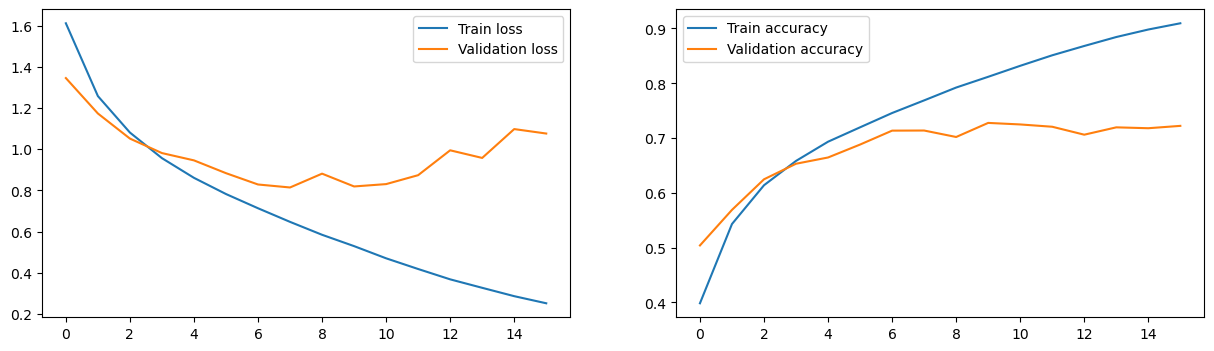

Best validation accuracy: 0.728
Early stopping triggered.
Training time:  5440.064206600189


In [35]:
from IPython.display import clear_output
from torch import optim
import time

t0 = time.time()

# Trains on CUDA GPU if possible; it is on my laptop and I don't wanna wait a trillion years to train
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Wave.to(device)
Wave.train() 
print_interval = 25
debug = False

# Instantiating variables
top_val_acc = 0
loss = nn.CrossEntropyLoss()
min_val_loss = np.inf
optimiser = torch.optim.Adam(Wave.parameters(), lr = 0.0005)
n_epochs = 50
train_losses_list, val_losses_list, train_acc_list, val_acc_list = [], [], [], []

for n in range(n_epochs):
    # Tracking metrics for this epoch
    tot_train_loss = 0
    train_correct = 0 

    # Training loop
    for batch_idx, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        
        model_pred = Wave(X)
        loss_value = loss(model_pred, y)
        tot_train_loss += loss_value.item() * X.size(0)
        
        loss_value.backward()
        optimiser.step()
        optimiser.zero_grad()

        # Accuracy for this batch
        predicted_class = model_pred.argmax(dim = 1)
        train_correct += (predicted_class == y).float().sum().item()

        # Print progress every `print_interval` batches
        if (batch_idx + 1) % print_interval == 0 or (batch_idx + 1) == len(train_loader):
            print(f"Epoch: {n+1}/{n_epochs}, Training Batch: {batch_idx+1}/{len(train_loader)}")

    # Validation loop
    tot_val_loss = 0
    val_correct = 0  

    with torch.no_grad():
        Wave.eval()
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            
            model_pred = Wave(X)
            loss_value = loss(model_pred, y)
            tot_val_loss += loss_value.item() * X.size(0)

            # This is kind of hacky, but since argmax will only ever mark one predicted class
            # increases the counter if the CNN classifies correctly
            predicted_class = model_pred.argmax(dim = 1)
            val_correct += (predicted_class == y).float().sum().item()
        Wave.train()

    # Epoch statistics
    train_loss = tot_train_loss / len(train_loader.dataset)
    val_loss = tot_val_loss / len(test_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    # Append metrics for plotting
    train_losses_list.append(train_loss)
    val_losses_list.append(val_loss)
    train_acc_list.append(train_accuracy)
    val_acc_list.append(val_accuracy)

    # Checkpoint if validation accuracy increases
    if val_accuracy > top_val_acc:
        torch.save(Wave, 'wave_model_initial.model') # Save
        top_val_acc = val_accuracy
        count = 0
    else:
        count += 1

    # Clear output once per epoch and display epoch summary and plots
    clear_output(wait=True)
    print(f"Epoch {n+1}/{n_epochs} Summary")
    print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
    print(f"Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")

    # Plotting after each epoch
    plt.figure(figsize=(15, 4))
    plt.subplot(121)
    plt.plot(train_losses_list, label = 'Train loss')
    plt.plot(val_losses_list, label = 'Validation loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(train_acc_list, label = 'Train accuracy')
    plt.plot(val_acc_list, label = 'Validation accuracy')
    plt.legend()
    plt.show()

    print(f"Best validation accuracy: {top_val_acc:.3f}")

    # Early stopping
    if count == 6:
        print("Early stopping triggered.")
        t1 = time.time()
        total = t1-t0
        print("Training time: ", total)
        break